# Exercise 1: Performing multiple independent MD simulations in parallel

In this exercise, the goal is to run 4 indepedent standard NPT MD simulations of the NaCl system in parallel, each for 500 ps. This can be achieved by using the `-multidir` flag in the GROMACS `mdrun` command, which runs multiple simulations simultaneously in different folders. This exercise should be performed in an interactive session on Bridges-2, with 32 cores requested. 

In [8]:
%%bash
# Delete folders sim_*, if there is any. This is not necessary but convenient for rerunning the notebook. 
if ls -d sim_* >/dev/null 2>&1; then
  rm -rf sim_*
fi

To get started, we execute the following commands to set up the example.

In [2]:
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

n=4  # number of simulations
for i in $(seq 1 $n)
do
    mkdir sim_${i} && cd sim_${i} && cp ../../Inputs/NaCl/* .   # create a folder and copy over gro, top and mdp files
    mpirun -np 1 gmx_mpi grompp -f MD-NPT.mdp -c NaCl.gro -p NaCl.top -o NaCl_md.tpr -maxwarn 1 && cd ../  # Generate the tpr
done

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -772534579
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...


Number of degrees of freedom in T-Coupling group System is 645.00


Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106


Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NPT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

There was 1 warning


This run will generate roughly 9 Mb of data



GROMACS reminds you: "I'm a strong believer that ignorance is important in science. If you know too much, you start seeing reasons why things won't work. That's why its important to change your field to collect more ignorance." (Sydney Brenner)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk  

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -1748455798
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NPT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

There was 1 warning

GROMACS reminds you: "XML is not a language in the sense of a programming language any more than sketches on a napkin are a language." (Charles Simonyi)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iup

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -2129450456
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NPT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

There was 1 warning

GROMACS reminds you: "... yet the [economic] profession continued to churn out purely theoretical results without even knowing what facts needed to be explained." (Thomas Piketty)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. E

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 2143205672
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NPT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

There was 1 warning

GROMACS reminds you: "I Smell Smoke From a Gun Named Extinction" (Pixies)



For each simulation, the commands above did the following:
- Create a folder with the file name in the form of `sim_*`.
- Copy the input files, including `NaCl.gro`, `NaCl.top`, and `NPT-MD.mdp`, to the folder.
- Run the GROMACS `grompp` command in the folder to generate the input `tpr` file.

After setting up the simulation inputs, we can run the GROMACS `mdrun` command. Note that the `mdrun` command should be executed one level above the `sim_*` directories (which is the working directory for each cell in this notebook).

In [3]:
%%time
%%bash
module load gromacs/2020.2-cpu
module load openmpi/4.0.5-gcc10.2.0

mpirun -np 8 gmx_mpi mdrun -s NaCl_md.tpr -deffnm output -multidir sim_1 sim_2 sim_3 sim_4 -ntomp 2


The following have been reloaded with a version change:
  1) openmpi/3.1.6-gcc10.2.0 => openmpi/4.0.5-gcc10.2.0

                  :-) GROMACS - gmx mdrun, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolaine

CPU times: user 70.2 ms, sys: 11.6 ms, total: 81.8 ms
Wall time: 38.5 s


- `-np` specifies the number of MPI processes to run the 4 simulations and has to be a multiple of 4.
- `-ntomp` specifies the number of OpenMP threads per MPI process. Generally, each OpenMP thread uses a CPU core.

In this example, we ran the simulations with 8 MPI processes, each with 2 OpenMP threads per MPI process. This means: 

- Each of the 4 simulation was performed with 2 MPI processes, and the workload (e.g. the calculation of interactions) of running a simulation was further divided by 2 threads. 

- A total of 16 CPU cores were used to run the 4 simulations.

- That is, 16 CPU cores were idle during the simulation, so we could have only requested 16 cores when launching the interactive session by using `--ntasks-per-node=16`. (Here we requested 32 cores just for the scaling test in the next section.) 

With this setup, it took about 45 seconds to finish all 4 simulations. As can be checked, now we have simulation outputs in each `sim_*` folder.

## Now, it's your turn! 👨‍💻

In the example above, we used 8 MPI processes (denoted as `np`), with 2 OpenMP threads per MPI process (denoted as `ntomp`), to run 4 simulations in parrallel. To determine a more efficient/cost-effective way to allocate comptuational resources for running MD simulations, it is common to perform a scaling test. This involves timing several short simulations with varying values of `np` or `ntomp`. By plotting the performance, such as ns/day (as demonstrated in the bottom of the log file), against `np` or `ntomp`, we can determine the cutoff point where the performance becomes sublinear.

As an exercise, try running 4 simulations of NaCl in parallel using 4 different values of `ntomp`, including 1, 2, 4, and 8, while keeping `np` fixed at 4. Then, plot the performance as a function of the **the number of cores** and answer the following question: **What is the optimal number of OpenMP threads per MPI process required to run 4 standard MD simulations for the NaCl system with 4 MPI processes?**

Note that
- We could have requested 128 cores to test a wider range of the number of cores. Here we requested only 32 cores considering available computing resources for the workshop.
- The optimal number of `np`/`ntomp` for running MD simulations may vary depending on the system being studied and the simulation method used. Therefore, it is generally good practice to conduct a scaling test when kicking off a new proejct.

To extract the performance of a simulation from its log file, you may find the following function useful.

In [4]:
def get_performance(log):
    with open(log, 'r') as f:
        lines = f.readlines()
    for l in lines:
        if 'Performance' in l:
            return float(l.split()[1])

    print('Simulation not finished.')

## Solution

In [5]:
%%time
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

ntomp=(1 2 4 8)  # 8 is the maximum since we have 128 cores and we fix np at 4
for i in "${ntomp[@]}"
do
    mpirun -np 4 gmx_mpi mdrun -s NaCl_md -deffnm output_$i -multidir sim_1 sim_2 sim_3 sim_4 -ntomp $i
done

                  :-) GROMACS - gmx mdrun, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

      Consider using -pin on (and -pinoffset in case you run multiple jobs).

NOTE: The number of threads is not equal to the number of (logical) cores
      and the -pin option is set to auto: will not pin threads to cores.
      This can lead to significant performance degradation.
      Consider using -pin on (and -pinoffset in case you run multiple jobs).

NOTE: The number of threads is not equal to the number of (logical) cores
      and the -pin option is set to auto: will not pin threads to cores.
      This can lead to significant performance degradation.
      Consider using -pin on (and -pinoffset in case you run multiple jobs).

NOTE: The number of threads is not equal to the number of (logical) cores
      and the -pin option is set to auto: will not pin threads to cores.
      This can lead to significant performance degradation.
      Consider using -pin on (and -pinoffset in case you run multiple jobs).
starting mdrun 'NaCl in water'
250000 steps,    500.0 ps.
starting m


Reading file NaCl_md.tpr, VERSION 2020.2-MODIFIED (single precision)
Reading file NaCl_md.tpr, VERSION 2020.2-MODIFIED (single precision)
Reading file NaCl_md.tpr, VERSION 2020.2-MODIFIED (single precision)
Reading file NaCl_md.tpr, VERSION 2020.2-MODIFIED (single precision)
Changing nstlist from 10 to 25, rlist from 0.607 to 0.67

Changing nstlist from 10 to 25, rlist from 0.607 to 0.67

Changing nstlist from 10 to 25, rlist from 0.607 to 0.67

Changing nstlist from 10 to 25, rlist from 0.607 to 0.67

This is simulation 0 out of 4 running as a composite GROMACS
multi-simulation job. Setup for this simulation:

Using 1 MPI process
This is simulation 3 out of 4 running as a composite GROMACS
multi-simulation job. Setup for this simulation:

Using 1 MPI process
This is simulation 2 out of 4 running as a composite GROMACS
multi-simulation job. Setup for this simulation:

Using 1 MPI process
This is simulation 1 out of 4 running as a composite GROMACS
multi-simulation job. Setup for this 

CPU times: user 203 ms, sys: 19.3 ms, total: 222 ms
Wall time: 2min 12s


As shown above, we tried running the simulations using 1, 2, 4, and 8 OpenMP threads per MPI process. Ideally, is should take about 2 minutes to complete the execution of the cell above. From the bottom of each log file, we can get the performance in ns/day for each case, which we can plot below. (Note that the result may vary for different runs, especially for a such small system. However, for larger systems (which are more common), there should be a kink point beyond which the performance becomes sublinear.) 

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rc

# Just some settings for plotting
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10,
})
# Set the font used for MathJax - more on thiprint(images)
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

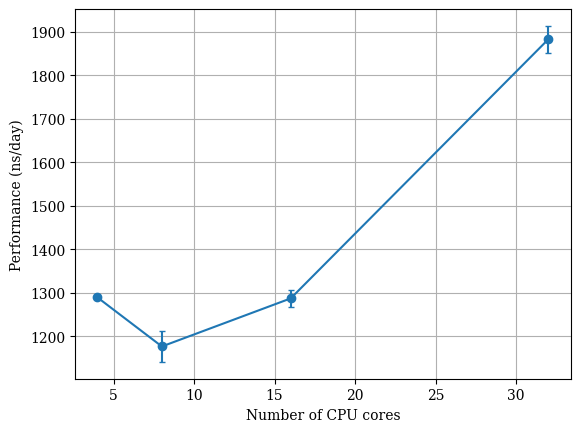

In [7]:
import numpy as np
n_mpi = 4
ntomp = np.array([1, 2, 4, 8])
p_avg, p_std = [], []
for i in ntomp:
    p_list = []
    for j in range(1, 5):  # from sim_1 to sim_4
        p_list.append(get_performance(f'sim_{j}/output_{i}.log'))
    p_avg.append(np.mean(p_list))
    p_std.append(np.std(p_list))

plt.figure()
plt.errorbar(ntomp * n_mpi, p_avg, yerr=p_std, marker='o', capsize=2)
plt.xlabel('Number of CPU cores')
plt.ylabel('Performance (ns/day)')
plt.grid()